In [53]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [54]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc   #.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale  #.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

In [55]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [56]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [57]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cpu")
#torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [58]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [59]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [60]:
def plot_vae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [64]:
### Jamie trying to understand train_loader here ###

print(len(train_loader))

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

188
Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


	 partial train loss (single batch): 69333.109375
	 partial train loss (single batch): 67577.343750
	 partial train loss (single batch): 66281.273438
	 partial train loss (single batch): 64528.222656
	 partial train loss (single batch): 63452.308594
	 partial train loss (single batch): 62094.601562
	 partial train loss (single batch): 61175.886719
	 partial train loss (single batch): 60750.015625
	 partial train loss (single batch): 60042.968750
	 partial train loss (single batch): 59424.246094
	 partial train loss (single batch): 58868.070312
	 partial train loss (single batch): 58277.218750
	 partial train loss (single batch): 57549.371094
	 partial train loss (single batch): 57244.222656
	 partial train loss (single batch): 56906.160156
	 partial train loss (single batch): 56369.214844
	 partial train loss (single batch): 55495.285156
	 partial train loss (single batch): 55488.617188
	 partial train loss (single batch): 54934.839844
	 partial train loss (single batch): 54861.015625


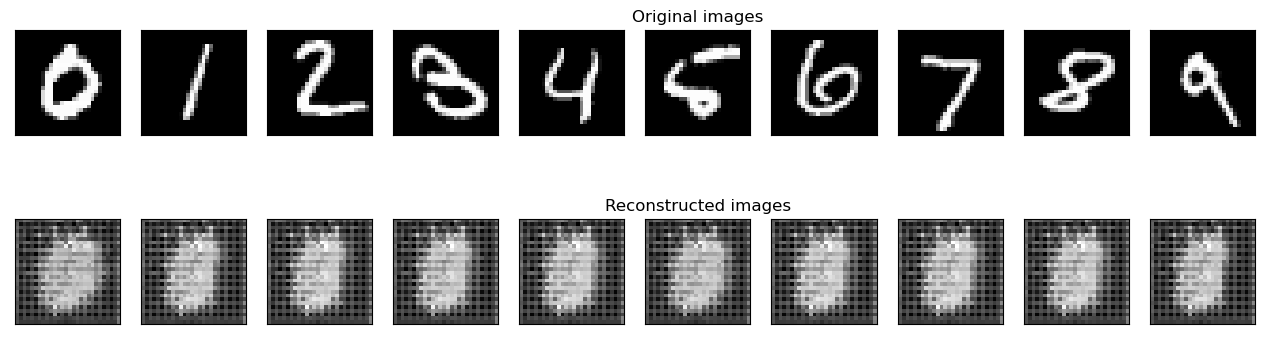

	 partial train loss (single batch): 20051.746094
	 partial train loss (single batch): 19985.369141
	 partial train loss (single batch): 19902.939453
	 partial train loss (single batch): 19933.734375
	 partial train loss (single batch): 19746.175781
	 partial train loss (single batch): 19702.957031
	 partial train loss (single batch): 19650.064453
	 partial train loss (single batch): 19470.164062
	 partial train loss (single batch): 19399.613281
	 partial train loss (single batch): 19306.931641
	 partial train loss (single batch): 19155.113281
	 partial train loss (single batch): 19269.242188
	 partial train loss (single batch): 19279.386719
	 partial train loss (single batch): 19020.718750
	 partial train loss (single batch): 19045.046875
	 partial train loss (single batch): 18897.533203
	 partial train loss (single batch): 19179.208984
	 partial train loss (single batch): 18990.042969
	 partial train loss (single batch): 18846.994141
	 partial train loss (single batch): 18702.681641


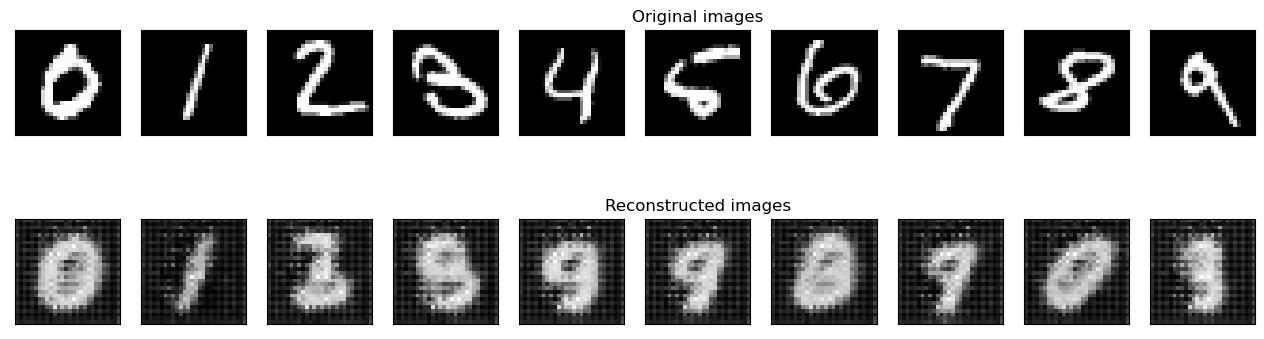

	 partial train loss (single batch): 13329.788086
	 partial train loss (single batch): 13506.470703
	 partial train loss (single batch): 13132.200195
	 partial train loss (single batch): 13441.605469
	 partial train loss (single batch): 13307.239258
	 partial train loss (single batch): 13399.005859
	 partial train loss (single batch): 13299.493164
	 partial train loss (single batch): 13051.590820
	 partial train loss (single batch): 12951.153320
	 partial train loss (single batch): 12870.995117
	 partial train loss (single batch): 12987.602539
	 partial train loss (single batch): 12977.657227
	 partial train loss (single batch): 13178.364258
	 partial train loss (single batch): 12854.525391
	 partial train loss (single batch): 12979.109375
	 partial train loss (single batch): 12926.671875
	 partial train loss (single batch): 13286.671875
	 partial train loss (single batch): 13152.451172
	 partial train loss (single batch): 13183.107422
	 partial train loss (single batch): 12805.161133


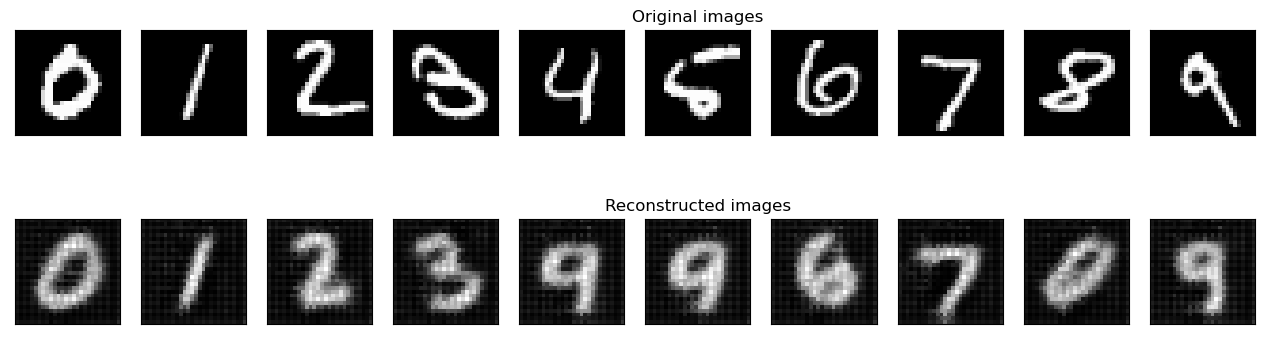

	 partial train loss (single batch): 10691.783203
	 partial train loss (single batch): 11093.701172
	 partial train loss (single batch): 10733.210938
	 partial train loss (single batch): 11121.002930
	 partial train loss (single batch): 10779.727539
	 partial train loss (single batch): 10870.029297
	 partial train loss (single batch): 10912.952148
	 partial train loss (single batch): 10650.361328
	 partial train loss (single batch): 10398.099609
	 partial train loss (single batch): 10449.368164
	 partial train loss (single batch): 10605.377930
	 partial train loss (single batch): 10666.084961
	 partial train loss (single batch): 10865.850586
	 partial train loss (single batch): 10494.474609
	 partial train loss (single batch): 10497.319336
	 partial train loss (single batch): 10646.701172
	 partial train loss (single batch): 10935.094727
	 partial train loss (single batch): 10763.929688
	 partial train loss (single batch): 10950.960938
	 partial train loss (single batch): 10429.431641


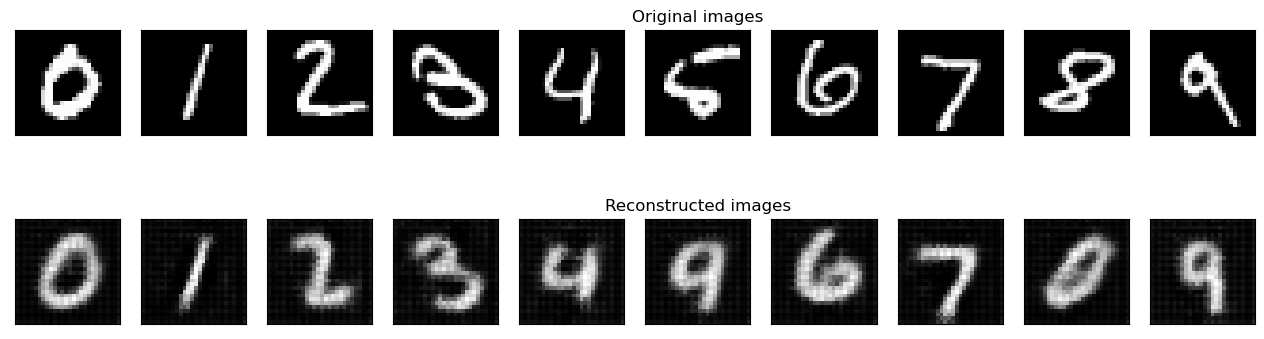

	 partial train loss (single batch): 9610.537109
	 partial train loss (single batch): 10099.700195
	 partial train loss (single batch): 9663.599609
	 partial train loss (single batch): 10230.811523
	 partial train loss (single batch): 10085.404297
	 partial train loss (single batch): 9898.976562
	 partial train loss (single batch): 9995.073242
	 partial train loss (single batch): 9714.402344
	 partial train loss (single batch): 9498.516602
	 partial train loss (single batch): 9570.862305
	 partial train loss (single batch): 9657.037109
	 partial train loss (single batch): 9764.414062
	 partial train loss (single batch): 9920.923828
	 partial train loss (single batch): 9588.499023
	 partial train loss (single batch): 9704.458008
	 partial train loss (single batch): 9780.225586
	 partial train loss (single batch): 9994.417969
	 partial train loss (single batch): 9882.428711
	 partial train loss (single batch): 10089.044922
	 partial train loss (single batch): 9532.909180
	 partial train 

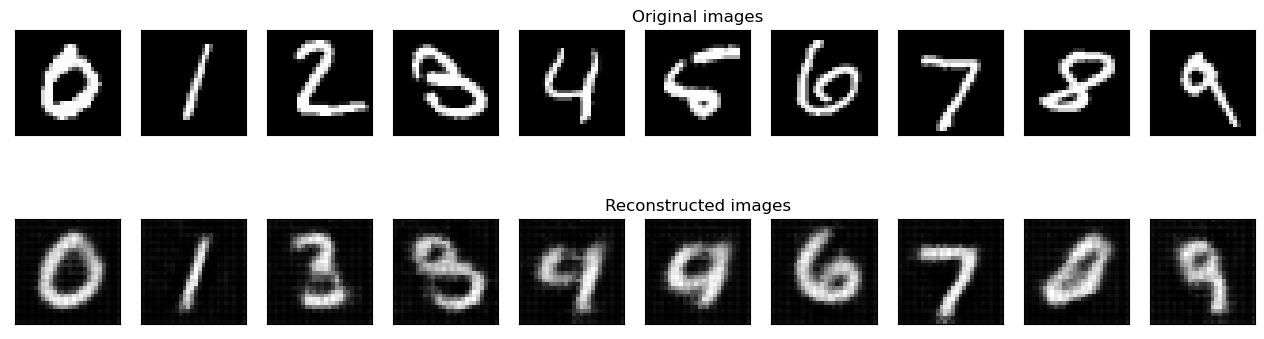

	 partial train loss (single batch): 9184.729492
	 partial train loss (single batch): 9722.523438
	 partial train loss (single batch): 9313.535156
	 partial train loss (single batch): 9699.438477
	 partial train loss (single batch): 9552.479492
	 partial train loss (single batch): 9454.748047
	 partial train loss (single batch): 9496.420898
	 partial train loss (single batch): 9210.023438
	 partial train loss (single batch): 9258.964844
	 partial train loss (single batch): 9187.507812
	 partial train loss (single batch): 9215.899414
	 partial train loss (single batch): 9281.533203
	 partial train loss (single batch): 9513.117188
	 partial train loss (single batch): 9229.487305
	 partial train loss (single batch): 9315.525391
	 partial train loss (single batch): 9414.179688
	 partial train loss (single batch): 9632.983398
	 partial train loss (single batch): 9538.525391
	 partial train loss (single batch): 9638.818359
	 partial train loss (single batch): 9184.187500
	 partial train loss

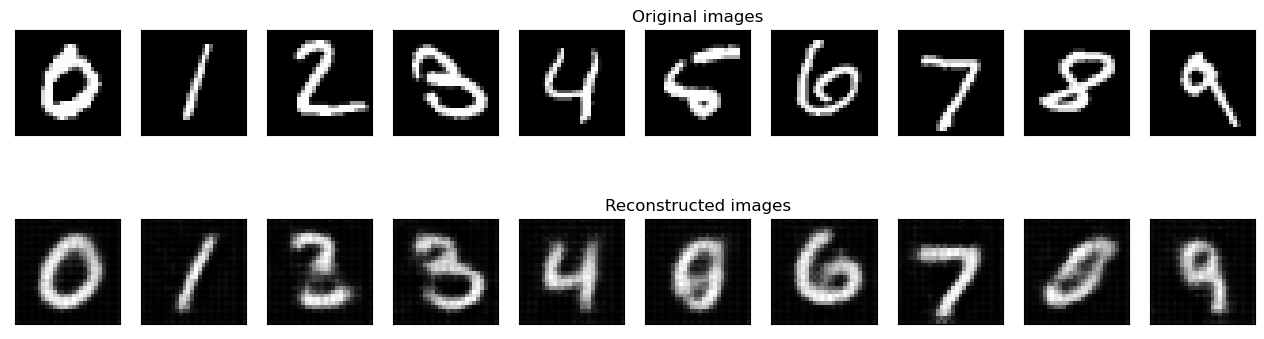

	 partial train loss (single batch): 8970.680664
	 partial train loss (single batch): 9475.201172
	 partial train loss (single batch): 9016.219727
	 partial train loss (single batch): 9514.926758
	 partial train loss (single batch): 9270.830078
	 partial train loss (single batch): 9144.577148
	 partial train loss (single batch): 9235.959961
	 partial train loss (single batch): 9028.093750
	 partial train loss (single batch): 8929.495117
	 partial train loss (single batch): 8872.264648
	 partial train loss (single batch): 8974.318359
	 partial train loss (single batch): 9079.799805
	 partial train loss (single batch): 9267.750977
	 partial train loss (single batch): 9008.007812
	 partial train loss (single batch): 9050.228516
	 partial train loss (single batch): 9076.896484
	 partial train loss (single batch): 9383.205078
	 partial train loss (single batch): 9312.071289
	 partial train loss (single batch): 9367.898438
	 partial train loss (single batch): 8961.186523
	 partial train loss

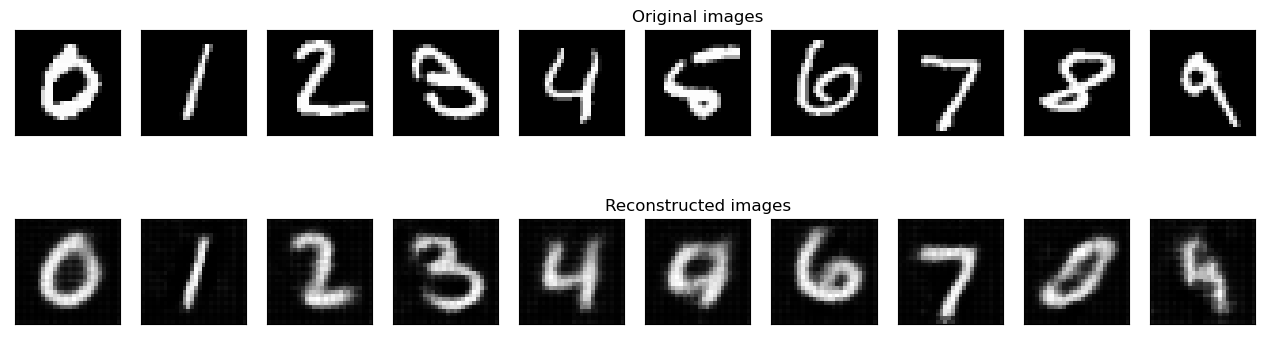

	 partial train loss (single batch): 8895.326172
	 partial train loss (single batch): 9292.870117
	 partial train loss (single batch): 8875.760742
	 partial train loss (single batch): 9370.314453
	 partial train loss (single batch): 9184.533203
	 partial train loss (single batch): 8964.449219
	 partial train loss (single batch): 9080.214844
	 partial train loss (single batch): 8866.132812
	 partial train loss (single batch): 8744.057617
	 partial train loss (single batch): 8866.041016
	 partial train loss (single batch): 8835.218750
	 partial train loss (single batch): 8808.609375
	 partial train loss (single batch): 9102.234375
	 partial train loss (single batch): 8926.752930
	 partial train loss (single batch): 8847.560547
	 partial train loss (single batch): 8928.586914
	 partial train loss (single batch): 9281.542969
	 partial train loss (single batch): 9136.601562
	 partial train loss (single batch): 9198.430664
	 partial train loss (single batch): 8824.980469
	 partial train loss

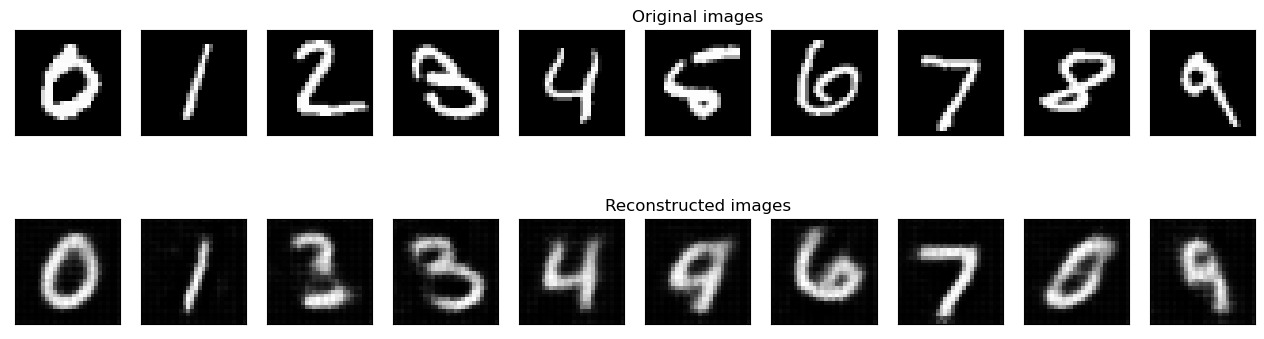

	 partial train loss (single batch): 8850.979492
	 partial train loss (single batch): 9207.462891
	 partial train loss (single batch): 8841.087891
	 partial train loss (single batch): 9263.979492
	 partial train loss (single batch): 9098.126953
	 partial train loss (single batch): 8912.886719
	 partial train loss (single batch): 8973.791016
	 partial train loss (single batch): 8754.451172
	 partial train loss (single batch): 8694.424805
	 partial train loss (single batch): 8822.736328
	 partial train loss (single batch): 8788.499023
	 partial train loss (single batch): 8735.341797
	 partial train loss (single batch): 8981.213867
	 partial train loss (single batch): 8829.279297
	 partial train loss (single batch): 8833.006836
	 partial train loss (single batch): 8958.805664
	 partial train loss (single batch): 9191.671875
	 partial train loss (single batch): 8993.439453
	 partial train loss (single batch): 9160.271484
	 partial train loss (single batch): 8793.644531
	 partial train loss

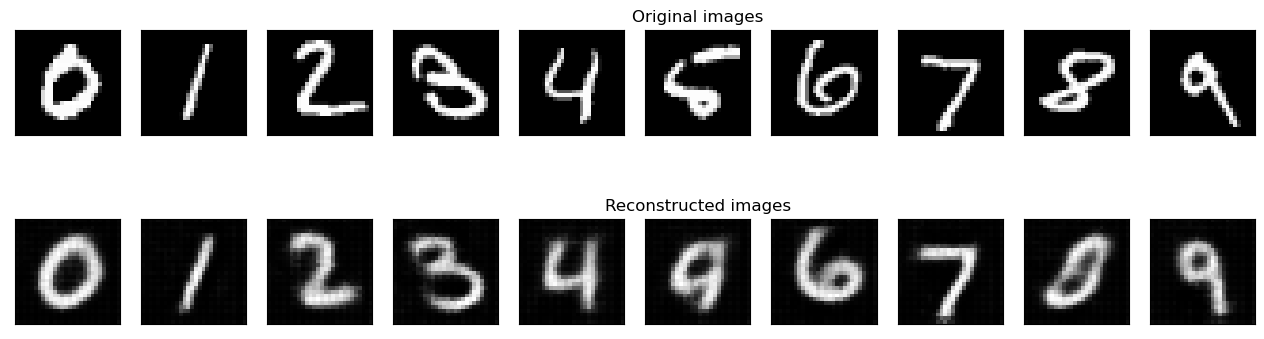

	 partial train loss (single batch): 8700.054688
	 partial train loss (single batch): 9087.791992
	 partial train loss (single batch): 8743.623047
	 partial train loss (single batch): 9165.557617
	 partial train loss (single batch): 8926.941406
	 partial train loss (single batch): 8794.903320
	 partial train loss (single batch): 8876.796875
	 partial train loss (single batch): 8611.556641
	 partial train loss (single batch): 8647.138672
	 partial train loss (single batch): 8562.416016
	 partial train loss (single batch): 8630.214844
	 partial train loss (single batch): 8603.931641
	 partial train loss (single batch): 8919.749023
	 partial train loss (single batch): 8648.041992
	 partial train loss (single batch): 8750.609375
	 partial train loss (single batch): 8844.428711
	 partial train loss (single batch): 9073.727539
	 partial train loss (single batch): 8889.869141
	 partial train loss (single batch): 9052.746094
	 partial train loss (single batch): 8683.994141
	 partial train loss

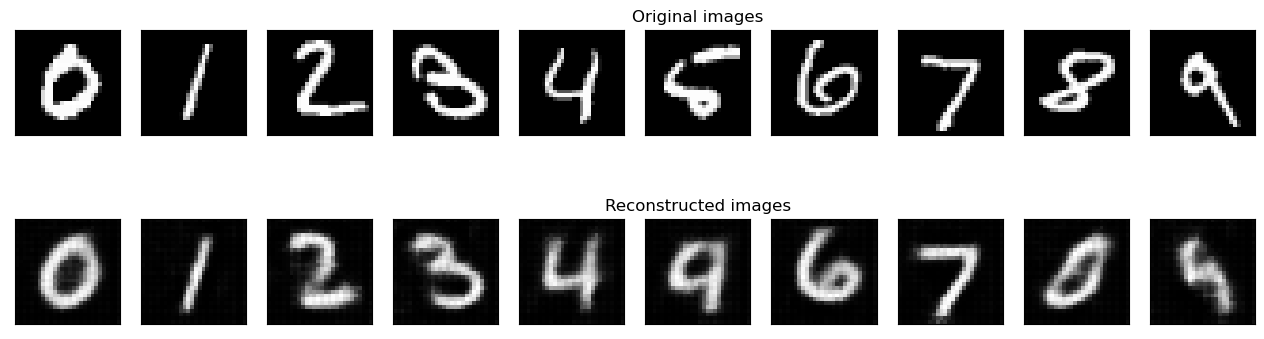

In [61]:
num_epochs = 10

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_vae_outputs(vae.encoder,vae.decoder,n=10)

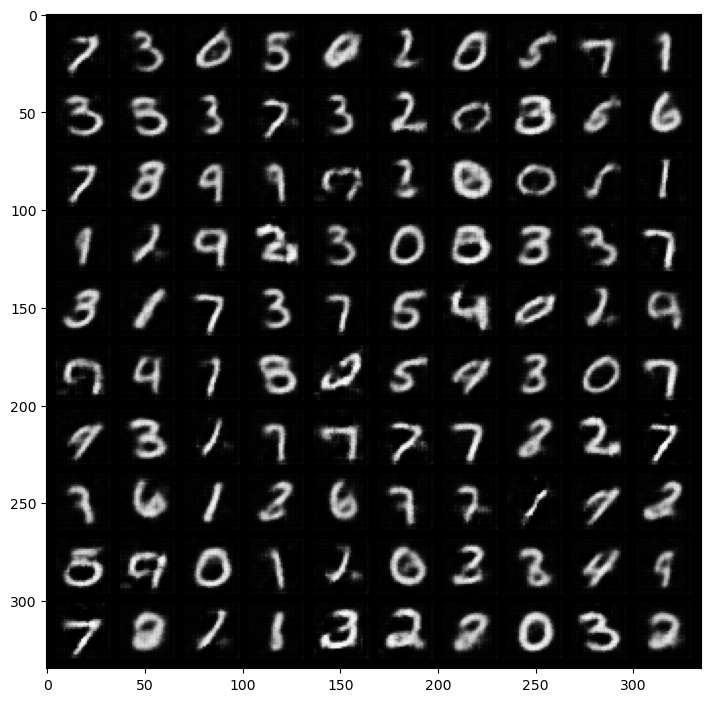

In [43]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

In [50]:
from tqdm import tqdm
import sklearn

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


100%|██████████| 10000/10000 [00:18<00:00, 536.72it/s]


In [51]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()